In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Conv2DTranspose, AveragePooling2D, Add, Reshape
from scipy.interpolate import RectBivariateSpline
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Boundary import Boundary1D
from MergeWithAttention import MergeWithAttention2
from collections.abc import Iterable
from conv_laplacian_loss import conv_laplacian_loss
import itertools, h5py
from multiprocessing import Pool as ThreadPool
from Lp_integral_norm import Lp_integral_norm
from Upsample import Upsample
opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.95)
conf = tf.ConfigProto(gpu_options=opts)
tfe.enable_eager_execution(config=conf)
tf.keras.backend.set_floatx('float64')

In [ ]:
ntest = 64
h = 0.05
folder = 'dataset_' + str(ntest)

In [3]:
for i in range(0,5):
    with h5py.File(folder + '/range_0_1/dataset' + str(i) + '_01.h5', 'r') as hf:
        F = np.array(hf.get('F'), dtype = np.float64)
        soln = np.array(hf.get('soln'), dtype = np.float64)
        try:
            train_data = train_data.concatenate(tf.data.Dataset.from_tensor_slices((F,soln)))
        except:
            train_data = tf.data.Dataset.from_tensor_slices((F,soln))

In [ ]:
for i in range(5,6):
    with h5py.File(folder + '/range_0_1/dataset' + str(i) + '_01.h5', 'r') as hf:
        F = np.array(hf.get('F'), dtype = np.float64)
        soln = np.array(hf.get('soln'), dtype = np.float64)
        try:
            valid_data = valid_data.concatenate(tf.data.Dataset.from_tensor_slices((F,soln)))
        except:
            valid_data = tf.data.Dataset.from_tensor_slices((F,soln))

In [3]:
with h5py.File(folder + '/dataset0_-11_constant_alt.h5', 'r') as hf:
    F = np.array(hf.get('F'), dtype = np.float64)
    soln = np.array(hf.get('soln'), dtype = np.float64)
    try:
        train_data_const = train_data.concatenate(tf.data.Dataset.from_tensor_slices((F,soln)))
    except:
        train_data_const = tf.data.Dataset.from_tensor_slices((F,soln))

In [ ]:
shuffle_size = 100000
batch_size = 200
#train_data = train_data.shuffle(shuffle_size).batch(batch_size)
#train_data_const = train_data_const.shuffle(shuffle_size).batch(batch_size)
valid_data = valid_data.shuffle(shuffle_size).batch(batch_size)
#del F, soln, train_data_const

In [3]:
from fluidnet_influenced_model import fluidnet_influenced
#b_01 = fluidnet_influenced(np.array((ntest,ntest)), load_weights_from = folder + '/model_test_denseupscaling_decomp.h5', downsampling_layer = 'Conv2D', upsampling_layer = 'Dense', intermediate_channels = 4, final_activation = 'linear', dense_upscaling_max_flatten_size=64)
#b_01 = fluidnet_influenced(np.array((ntest,ntest)), load_weights_from = folder + '/model_test_denseupscaling_decomp.h5', downsampling_layer = 'Conv2D', upsampling_layer = 'Dense', intermediate_channels = 4, final_activation = 'linear', dense_upscaling_max_flatten_size=64)
#b_01.summary()

In [21]:
b_01.compile(optimizer = tf.train.AdamOptimizer(learning_rate=1e-5), loss = Lp_integral_norm((64,64), domain = [0,ntest*h,0,ntest*h], n_quadpts = 20, quadpts_randomization = 2, mse_component_weight = 1e+0), metrics = ['mse','mae'])

In [ ]:
b_01.fit(train_data, steps_per_epoch=50, epochs=20, validation_data=valid_data, validation_steps=3)

In [42]:
b_01.save_weights(folder + '/model_test_denseupscaling_decomp.h5')

In [4]:
from constant_rhs_to_soln_model import constant_rhs_to_soln_dense
b_const = constant_rhs_to_soln_dense(np.array((ntest,ntest)), load_weights_from=folder + '/model_test_const_dense.h5')

In [18]:
b_const.compile(optimizer = tf.train.AdamOptimizer(learning_rate=1e-4), loss = 'mse')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense (Dense)                (None, 4096)              8192      
_________________________________________________________________
reshape (Reshape)            (None, 1, 64, 64)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 64, 64)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 64, 64)         1160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 64, 64)         73        
Total params: 9,585
Trainable params: 9,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
while True:
    b_const.fit(train_data_const, steps_per_epoch=20, epochs=10)

In [19]:
b_const.save_weights(folder + '/model_test_const_dense.h5')

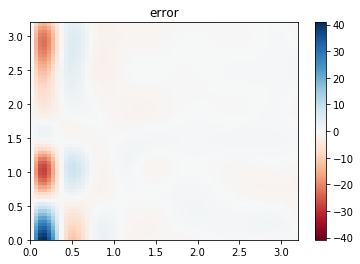

In [27]:
#plotting
#p = valid_data.make_one_shot_iterator().get_next()
#p_r = np.random.randint(0,batch_size)
y, x = np.meshgrid(np.linspace(0, ntest*h, ntest), np.linspace(0, ntest*h, ntest))
#z = b_01.predict(tf.expand_dims(p[0][p_r,...], axis=0))[0,0,...]
#z = p[1][p_r,0,...]
z = batch[0][21,0,...]
#z = b_01.predict(tf.expand_dims(p[0][p_r,...], axis=0))[0,0,...] - p[1][p_r,0,...]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('error')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()

In [27]:
#mean % error
tf.reduce_mean(tf.abs(b_01.predict(p[0][...]) - p[1][...]))/tf.reduce_mean(tf.abs(p[1][...]))

<tf.Tensor: id=11985869, shape=(), dtype=float64, numpy=0.012471161810072>

In [34]:
cll = conv_laplacian_loss((ntest,ntest),h)
cll(b.predict(p[0]), p[1])
#cll(b.predict(tf.ones((1,1,ntest,ntest), dtype=tf.keras.backend.floatx())),tf.ones((1,1,ntest,ntest), dtype=tf.keras.backend.floatx()))

<tf.Tensor: id=5410203, shape=(), dtype=float64, numpy=0.5258203600722624>

In [5]:
for i in range(0,5):
    with h5py.File(folder + '/range_-1_1/dataset' + str(i) + '_-11.h5', 'r') as hf:
        F = np.array(hf.get('F'), dtype = np.float64)
        soln = np.array(hf.get('soln'), dtype = np.float64)
        try:
            train_data = train_data.concatenate(tf.data.Dataset.from_tensor_slices((F,soln)))
        except:
            train_data = tf.data.Dataset.from_tensor_slices((F,soln))

In [6]:
for i in range(5,6):
    with h5py.File(folder + '/range_-1_1/dataset' + str(i) + '_-11.h5', 'r') as hf:
        F = np.array(hf.get('F'), dtype = np.float64)
        soln = np.array(hf.get('soln'), dtype = np.float64)
        try:
            valid_data = train_data.concatenate(tf.data.Dataset.from_tensor_slices((F,soln)))
        except:
            valid_data = tf.data.Dataset.from_tensor_slices((F,soln))

In [ ]:
@tfe.defun
def batch_normalize(batch):
    lower_bounds = tf.map_fn(tf.reduce_min,batch)
    upper_bounds = tf.map_fn(tf.reduce_max,batch)
    alpha = upper_bounds-lower_bounds
    g = tf.map_fn(lambda x: (x[0]-x[1])/x[2], (batch, lower_bounds, alpha), dtype = tf.float64)#(f-d)/alpha
    return g, lower_bounds, alpha

In [18]:
#p = train_data.make_one_shot_iterator()
#loss_function = Lp_integral_norm((64,64), domain = [0,ntest*h,0,ntest*h], n_quadpts = 20, quadpts_randomization = 2, mse_component_weight = 1e+1)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-8)

for i in range(2000):
    batch = p.get_next()
    with tf.GradientTape(persistent=True) as tape:
        g, lower_bounds, alpha = batch_normalize(batch[0])
        s = b_01(g)
        w = b_const(tf.expand_dims(lower_bounds, axis=1))
        res = tf.einsum('ijkl,i->ijkl',s,alpha) + w
        loss = loss_function(batch[1], res)
    grads_01 = tape.gradient(loss,b_01.trainable_variables)
    grads_const = tape.gradient(loss,b_const.trainable_variables)
    optimizer.apply_gradients(zip(grads_01, b_01.trainable_variables))
    optimizer.apply_gradients(zip(grads_const, b_const.trainable_variables))
    if i%10 == 0:
        print('-----------------')
        print('loss: ' + str(loss))
        print('mse error: ' + str(tf.losses.mean_squared_error(res, batch[1])))

-----------------
loss: tf.Tensor(0.27320203999523335, shape=(), dtype=float64)
mse error: tf.Tensor(0.011345396, shape=(), dtype=float32)
-----------------
loss: tf.Tensor(0.24348165505864608, shape=(), dtype=float64)
mse error: tf.Tensor(0.009324707, shape=(), dtype=float32)
-----------------
loss: tf.Tensor(0.15574794607405265, shape=(), dtype=float64)
mse error: tf.Tensor(0.002779319, shape=(), dtype=float32)
-----------------
loss: tf.Tensor(0.2853555083196846, shape=(), dtype=float64)
mse error: tf.Tensor(0.012810357, shape=(), dtype=float32)
-----------------
loss: tf.Tensor(0.14641662053437454, shape=(), dtype=float64)
mse error: tf.Tensor(0.0022181466, shape=(), dtype=float32)
-----------------
loss: tf.Tensor(0.15403973020359568, shape=(), dtype=float64)
mse error: tf.Tensor(0.002886753, shape=(), dtype=float32)
-----------------
loss: tf.Tensor(0.14950518397687793, shape=(), dtype=float64)
mse error: tf.Tensor(0.0024825884, shape=(), dtype=float32)
-----------------
loss: tf

OutOfRangeError: End of sequence [Op:IteratorGetNextSync]

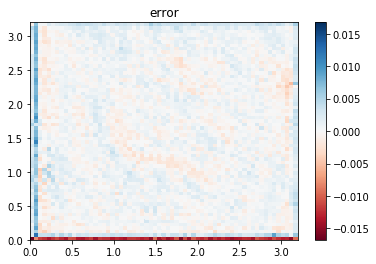

In [16]:
#p = test_data.make_one_shot_iterator().get_next()
#p_r = np.random.randint(0,batch_size)

y, x = np.meshgrid(np.linspace(0, ntest*h, ntest), np.linspace(0, ntest*h, ntest))
z = batch[1][p_r,0,...]#p[1][p_r,0,...]
z = res[p_r,0,...]
#z = res[p_r,0,...] - batch[1][p_r,0,...]#alpha * s[0,0,...] + d * q[0,0,...] - p[1][p_r,0,...]
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.set_title('error')
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

plt.show()